### Importing required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/NSP_Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NSP_Project


In [2]:
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_segmentation_masks

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import skimage.io as io
import torch
import torch.utils.data
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
import warnings
warnings.filterwarnings("ignore")

### Data Collection and Preprocessing

In [ ]:
path = "/content/drive/MyDrive/NSP_Project/images/val2017"
annotations = COCO("/content/drive/MyDrive/NSP_Project/annotations/annotations/instances_val2017.json")

categories = annotations.getCatIds()
image_ids = []
for category in categories:
    image_ids.extend(annotations.getImgIds(catIds=category))
    
image_ids = list(set(image_ids))
print(f"Number of training images: {len(image_ids)}")

### Creating the custom dataset
Reference: 
1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
2. https://pytorch.org/vision/stable/_modules/torchvision/datasets/coco.html

In [ ]:
class ImageData(torch.utils.data.Dataset):
    def __init__(self, annotations: COCO, img_ids, cat_ids, root_path):
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [os.path.join(root_path, img["file_name"]) for img in self.img_data]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
    

        img = io.imread(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)

        if self.transformation is not None:
            return self.transformation(img)

        return img, mask

#### Displaying images and masks from the dataset

In [ ]:
# Object of ImageData class for training
data_ = ImageData(annotations, image_ids, categories, path)

for i in range(5):
    img, mask = data_[i]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(TF.to_pil_image(img))

    plt.subplot(1, 2, 2)
    plt.title('Segmentation Mask')
    plt.imshow(mask.squeeze())

    plt.show()

### Pretrained Models
1. Mask R-CNN
2. Deeplabv3_mobilenet
3. Deeplabv3_resnet50

##### References:
1. https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#instance-seg-output

In [3]:
def mask_rcnn(input_batch):
    mask_rcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    mask_rcnn.eval()

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        mask_rcnn.to('cuda')

    with torch.no_grad():
        output = mask_rcnn(input_batch)
    
    output = output[0]
    proba_threshold = 0.5
    output_masks = output['masks'] > proba_threshold
    mask_rcnn_predictions = output_masks.squeeze(1)
    return mask_rcnn_predictions

In [4]:
def deeplab_mobilenet(input_batch):
    deeplab_mobilenet = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True) 
    deeplab_mobilenet.eval()

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        deeplab_mobilenet.to('cuda')

    with torch.no_grad():
        output = deeplab_mobilenet(input_batch)['out'][0]
    deeplab_mobilenet_predictions = output.argmax(0)

    return deeplab_mobilenet_predictions

In [5]:
def deeplab_resnet50(input_batch):
    deeplab_resnet50 = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    deeplab_resnet50.eval()

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        deeplab_resnet50.to('cuda')

    with torch.no_grad():
        output = deeplab_resnet50(input_batch)['out'][0]
    
    deeplab_resnet50_predictions = output.argmax(0)

    return deeplab_resnet50_predictions

### Custom MaskRCNN

In [6]:
def load_custom_maskrcnn(input_batch):
  # Loading the custom Mask RCNN model
  custom_maskrcnn = torch.load("/content/drive/MyDrive/NSP_Project/final_model.pth")
  custom_maskrcnn.eval()

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    custom_maskrcnn.to('cuda')

  with torch.no_grad():
    output = custom_maskrcnn(input_batch)

  masks = output[0]['masks']
    
  return masks

### Testing on images

In [19]:
def get_accuracy(ground_truth, prediction):
  '''
  Calculating the Intersection over Union(IoU) metric
  '''
  # Preprocessing the ground truth
  ground_truth = ground_truth.squeeze()
  ground_truth = ground_truth.cpu().numpy()

  # Pixels common between the ground truth and prediction
  intersection = np.logical_and(ground_truth, prediction)

  # Total pixels present in ground truth and preduction
  union = np.logical_or(ground_truth, prediction)

  # IoU score
  iou_score = np.sum(intersection) / np.sum(union)
  iou_score = iou_score*100

  return iou_score

In [ ]:
random_samples = np.random.randint(0, data_.__len__(), 10)

preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
for i in random_samples:

  # ----- Extracting the image and mask from custom dataset ----- #
    img, mask = data_[i]
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # (3, 428, 640) => (1, 3, 428, 640)

    plt.figure(figsize=(15, 9))

  # ----- Plotting Image ----- #
    plt.subplot(1, 6, 1)
    plt.title("Image")
    plt.imshow(TF.to_pil_image(img))
    plt.xticks([])
    plt.yticks([])

  # ----- Plotting Ground Truth Mask ----- #
    plt.subplot(1, 6, 2)
    plt.title("Ground Truth")
    plt.imshow(mask.squeeze())
    plt.xticks([])
    plt.yticks([])

    # ----- Custom Model ----- #
    custom_model = load_custom_maskrcnn(input_batch)
    mask_custom = custom_model.cpu().numpy()
    mask_custom = mask_custom[0] # [[....]]
    mask_custom = np.squeeze(mask_custom, axis=0)

    plt.subplot(1, 6, 3)
    plt.title("Custom Model")
    plt.imshow(mask_custom)
    plt.xlabel(f"IoU Score: {get_accuracy(mask, mask_custom):.2f}")
    plt.xticks([])
    plt.yticks([])

    # ----- Mask RCNN Model ----- #
    mask_rcnn_ = mask_rcnn(input_batch)
    mask_ = mask_rcnn_[0]
    mask_ = mask_.cpu().numpy()

    plt.subplot(1, 6, 4)
    plt.title("Mask RCNN")
    plt.imshow(mask_)
    plt.xlabel(f"IoU Score: {get_accuracy(mask, mask_):.2f}")
    plt.xticks([])
    plt.yticks([])

    # ----- DeepLab MobileNet ----- #
    deeplab_mobilenet_ = Image.fromarray(deeplab_mobilenet(input_batch).byte().cpu().numpy())

    plt.subplot(1, 6, 5)
    plt.title("DeepLabv3 MobileNet")
    plt.imshow(deeplab_mobilenet_)
    plt.xlabel(f"IoU Score: {get_accuracy(mask, deeplab_mobilenet_):.2f}")
    plt.xticks([])
    plt.yticks([])

    # ----- DeepLab ResNet50 ----- #
    deeplab_resnet50_ = Image.fromarray(deeplab_resnet50(input_batch).byte().cpu().numpy())

    plt.subplot(1, 6, 6)
    plt.title("DeepLabv3 Resnet50")
    plt.imshow(deeplab_resnet50_)
    plt.xlabel(f"IoU Score: {get_accuracy(mask, deeplab_resnet50_):.2f}")
    plt.xticks([])
    plt.yticks([])


    plt.show()

### Testing on real-world images

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

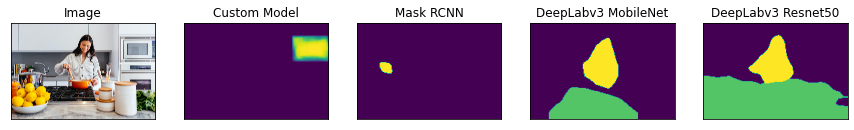

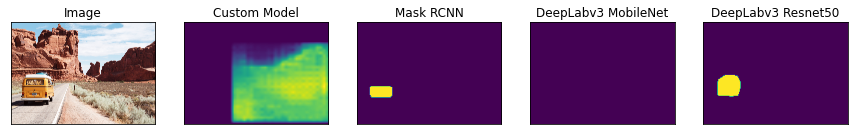

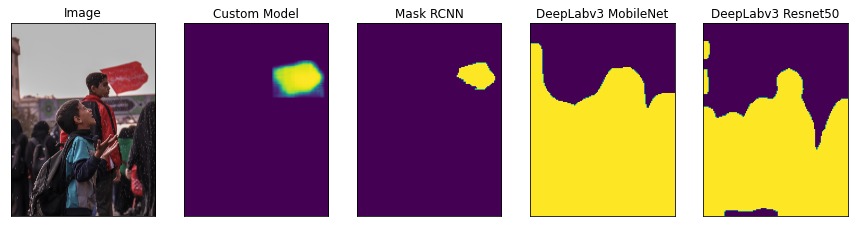

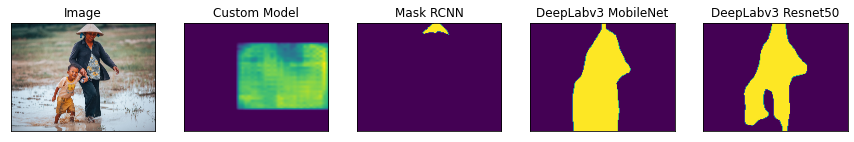

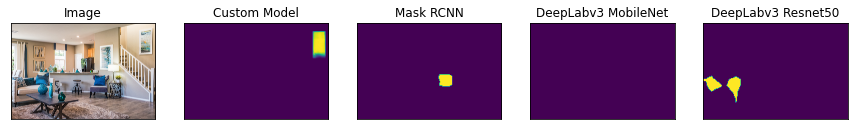

In [7]:
from PIL import Image
import glob

path = "/content/drive/MyDrive/NSP_Project/TestImages"


preprocess = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

for file in os.listdir(path):
  img_path = os.path.join(path, file)
  img = Image.open(img_path)

  input_tensor = preprocess(img)
  input_batch = input_tensor.unsqueeze(0) 

  plt.figure(figsize=(15, 9))

  # ----- Plotting Image ----- #
  plt.subplot(1, 5, 1)
  plt.title("Image")
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])


  # ----- Custom Model ----- #
  custom_model = load_custom_maskrcnn(input_batch)
  mask_custom = custom_model.cpu().numpy()
  mask_custom = mask_custom[0] # [[....]]
  mask_custom = np.squeeze(mask_custom, axis=0)

  plt.subplot(1, 5, 2)
  plt.title("Custom Model")
  plt.imshow(mask_custom)
  plt.xticks([])
  plt.yticks([])

    # ----- Mask RCNN Model ----- #
  mask_rcnn_ = mask_rcnn(input_batch)
  mask_ = mask_rcnn_[0]
  mask_ = mask_.cpu().numpy()

  plt.subplot(1, 5, 3)
  plt.title("Mask RCNN")
  plt.imshow(mask_)
  plt.xticks([])
  plt.yticks([])

    # ----- DeepLab MobileNet ----- #
  deeplab_mobilenet_ = Image.fromarray(deeplab_mobilenet(input_batch).byte().cpu().numpy())

  plt.subplot(1, 5, 4)
  plt.title("DeepLabv3 MobileNet")
  plt.imshow(deeplab_mobilenet_)
  plt.xticks([])
  plt.yticks([])

    # ----- DeepLab ResNet50 ----- #
  deeplab_resnet50_ = Image.fromarray(deeplab_resnet50(input_batch).byte().cpu().numpy())

  plt.subplot(1, 5, 5)
  plt.title("DeepLabv3 Resnet50")
  plt.imshow(deeplab_resnet50_)
  plt.xticks([])
  plt.yticks([])


  plt.show()